In [ ]:
%%capture

import numpy as np
import matplotlib.pyplot as plt

from nltk.tokenize import WordPunctTokenizer
from nltk.translate.bleu_score import corpus_bleu

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.rnn as rnn_utils

from sklearn.model_selection import train_test_split
from vocab import Vocab

from IPython.display import clear_output
from tqdm import tqdm, trange

%matplotlib inline

np.random.seed(998)

import warnings
warnings.filterwarnings('ignore')

### Загрузка данных

In [ ]:
!wget https://www.dropbox.com/s/yy2zqh34dyhv07i/data.txt?dl=1 -O data.txt

--2025-03-19 18:09:53--  https://www.dropbox.com/s/yy2zqh34dyhv07i/data.txt?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/mw8tdyetqboqwkn5ma886/data.txt?rlkey=t9fmsizx27ikh0vak0ir265a6&dl=1 [following]
--2025-03-19 18:09:53--  https://www.dropbox.com/scl/fi/mw8tdyetqboqwkn5ma886/data.txt?rlkey=t9fmsizx27ikh0vak0ir265a6&dl=1
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc6c7b7e454ee9f683dc7b7183d9.dl.dropboxusercontent.com/cd/0/inline/CmIdtMsT1MBgLRoaXK4_6EUrr78a3jPcp_rQoAgl1vCTAi-zWApwSAFkRhkxhkJo8wJq4A8bXFVL1e3FldvPjRA_ctSd5dU5s1MtZUtisYo4F3mYZU0zrTNmvzsKFD3Y-vM/file?dl=1# [following]
--2025-03-19 18:09:54--  https://uc6c7b7e454ee9f683dc7b7183d9.dl.dropboxusercontent.com/cd/0/inline/CmIdtMsT1MBgLR

In [ ]:
with open('data.txt') as f:
  print(f.readlines()[0])

Cordelia Hotel is situated in Tbilisi, a 3-minute walk away from Saint Trinity Church.	Отель Cordelia расположен в Тбилиси, в 3 минутах ходьбы от Свято-Троицкого собора.



### BPE

Сам токенизатор оставляем таким же, он хорошо подходит для задачи. Значительно увеличим размер словаря: до половины размера словаря GPT-2 – 25 тыс. токенов, это должно положительно повлиять на метрики.

In [ ]:
!pip install subword-nmt

In [ ]:
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

In [ ]:
tokenizer = WordPunctTokenizer()

def tokenize(x):
  return ' '.join(tokenizer.tokenize(x.lower()))

In [ ]:
with open('train.en', 'w') as f_src,  open('train.ru', 'w') as f_dst:
  for line in open('data.txt'):
    src_line, dst_line = line.strip().split('\t')
    f_src.write(tokenize(src_line) + '\n')
    f_dst.write(tokenize(dst_line) + '\n')

In [ ]:
bpe = {}
for lang in ['en', 'ru']:
    learn_bpe(open('./train.' + lang), open('bpe_rules.' + lang, 'w'), num_symbols=25000)
    bpe[lang] = BPE(open('./bpe_rules.' + lang))

    with open('train.bpe.' + lang, 'w') as f_out:
        for line in open('train.' + lang):
            f_out.write(bpe[lang].process_line(line.strip()) + '\n')

100%|██████████| 25000/25000 [00:39<00:00, 628.34it/s]


### Построение словарей

Здесь немного увеличим тестовую выборку - до 5 тыс. токенов


In [ ]:
data_inp = np.array(open('./train.bpe.ru').read().split('\n'))
data_out = np.array(open('./train.bpe.en').read().split('\n'))

train_inp, dev_inp, train_out, dev_out = train_test_split(
    data_inp,
    data_out,
    test_size=5000,
    random_state=998,
)

for i in range(3):
    print('inp:', train_inp[i])
    print('out:', train_out[i], end='\n\n')

inp: отель bellevue am kur@@ für@@ stend@@ am@@ m находится на тихой улоч@@ ке в 10 минутах ходьбы от знаменитого торгового бульвара курфюрстен@@ дам@@ м в берлине . до 2 станций метро можно дойти за несколько минут . гостям предлагают размещение в элегантных номерах .
out: situated a 10 - minute walk from berlin ' s famous kurfürstendamm shopping boulevard and within comfortable walking distance of 4 underground lines , this hotel offers elegant accommodation in a quiet side street .

inp: кроме того , в 400 метрах находится ресторан - парт@@ нер , в котором подают фирменные блюда региональной кухни .
out: a partner restaurant serving regional specialities is 400 metres away .

inp: здесь есть прихо@@ жая с 1 или 2 местами на двухъярусной кровати , гостиная / обеденная комната с 1 двуспальным диван - кроватью и телевизором , кухня ( 4 - конфоро@@ чная плита , мини - печь ), си@@ дя@@ чая ванна / туалет .
out: it has an entrance hall with 1 x 2 bunk beds ; living / dining room with 1 d

In [ ]:
inp_voc = Vocab.from_lines(train_inp)
out_voc = Vocab.from_lines(train_out)

In [ ]:
batch_lines = sorted(train_inp, key=len)[5:10]
batch_ids = inp_voc.to_matrix(batch_lines)
batch_lines_restored = inp_voc.to_lines(batch_ids)

print("lines")
print(batch_lines)
print("\nwords to ids (0 = bos, 1 = eos):")
print(batch_ids)
print("\nback to words")
print(batch_lines_restored)

lines
[np.str_('до афин — 20 км .'), np.str_('до туапсе 19 км .'), np.str_('работает боулинг .'), np.str_('оборудован балкон .'), np.str_('до флоренции 29 км .')]

words to ids (0 = bos, 1 = eos):
tensor([[    0,  8828,  6039, 22879,   103, 10871,    31,     1],
        [    0,  8828, 19784,    91, 10871,    31,     1,     1],
        [    0, 16171,  6661,    31,     1,     1,     1,     1],
        [    0, 13728,  6138,    31,     1,     1,     1,     1],
        [    0,  8828, 20625,   134, 10871,    31,     1,     1]])

back to words
['до афин — 20 км .', 'до туапсе 19 км .', 'работает боулинг .', 'оборудован балкон .', 'до флоренции 29 км .']


Распределения длин исходных текстов и переводов

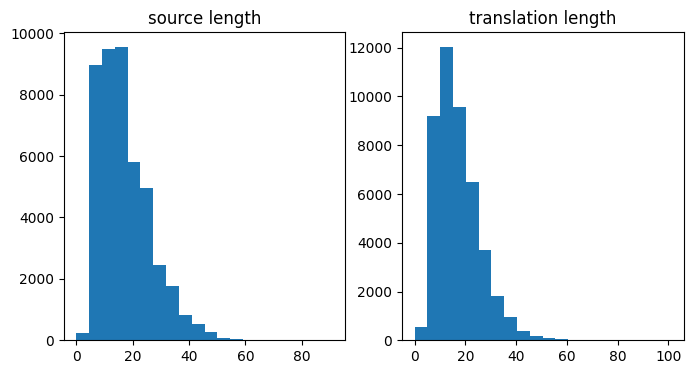

In [ ]:
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(map(len, map(str.split, train_inp))), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(map(len, map(str.split, train_out))), bins=20);

### Encoder-decoder model


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
device

'cuda'

Ура, у нас есть GPU. Изначально в модели было три слоя - энкодер, декодер и однослойный GRU. Попробуем использовать двухслойную LSTM вместо GRU, и скорректируем энкодер и декодер чтобы они учитывали новые состояния.

Также в decode_iference заменим жадное семплирование на top-k семплирование, для которого сделаем отдельую функцию. Оно самое быстрое и в теории может улучшить bleu

Я пробовала ядерное и beam-search и они очень долго считали bleu даже при различных ограничениях, поэтому оставила топ-к..

In [ ]:
class BasicModel(nn.Module):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128):
        """
        A simple encoder-decoder seq2seq model
        """
        super().__init__()

        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size

        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.emb_out = nn.Embedding(len(out_voc), emb_size)
        self.enc0 = nn.LSTM(emb_size, hid_size, num_layers=2, batch_first=True)

        self.dec_start = nn.Linear(hid_size, hid_size)
        self.dec0 = nn.LSTMCell(emb_size, hid_size)
        self.logits = nn.Linear(hid_size, len(out_voc))

    def forward(self, inp, out):
        """ Apply model in training mode """
        initial_state = self.encode(inp)
        return self.decode(initial_state, out)


    def encode(self, inp, lengths=None):
        inp_emb = self.emb_inp(inp)
        if lengths is None:
            lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1)

        # обрабатываем данные на входе чтобы игнорировать паддинг
        packed = rnn_utils.pack_padded_sequence(inp_emb, lengths.cpu(), batch_first=True, enforce_sorted=False)

        # пропускаем через LSTM
        enc_seq, (h_n, c_n) = self.enc0(packed)
        enc_seq, _ = rnn_utils.pad_packed_sequence(enc_seq, batch_first=True)

        # берем последние состояния из последнего слоя LSTM
        last_hidden = h_n[-1]
        last_cell   = c_n[-1]
        dec_start_h = self.dec_start(last_hidden)
        return [dec_start_h, last_cell]




    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits for next tokens
        :param prev_state: a list of previous decoder state tensors, same as returned by encode(...)
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch, len(out_voc)]
        """
        prev_h, prev_c = prev_state
        prev_emb = self.emb_out(prev_tokens)

        new_h, new_c = self.dec0(prev_emb, (prev_h, prev_c))
        output_logits = self.logits(new_h)
        return [new_h, new_c], output_logits


    def decode(self, initial_state, out_tokens, **flags):
        """ Iterate over reference tokens (out_tokens) with decode_step """
        batch_size = out_tokens.shape[0]
        state = initial_state

        # initial logits: always predict BOS
        onehot_bos = F.one_hot(torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64),
                               num_classes=len(self.out_voc)).to(device=out_tokens.device)
        first_logits = torch.log(onehot_bos.to(torch.float32) + 1e-9)

        logits_sequence = [first_logits]
        for i in range(out_tokens.shape[1] - 1):
            state, logits = self.decode_step(state, out_tokens[:, i])
            logits_sequence.append(logits)
        return torch.stack(logits_sequence, dim=1)

    def top_k_sample(self, logits, k=5, temperature=1.0):
        logits = logits / temperature
        top_k_logits, top_k_indices = torch.topk(logits, min(k, logits.size(-1)), dim=-1)
        top_k_probs = F.softmax(top_k_logits, dim=-1)
        sampled_indices_within_k = torch.multinomial(top_k_probs, num_samples=1).squeeze(-1)
        batch_indices = torch.arange(logits.size(0), device=logits.device)
        sampled_indices = top_k_indices[batch_indices, sampled_indices_within_k]

        return sampled_indices

    def decode_inference(self, initial_state, max_len=100, k=3, temperature=0.9, **flags):
        """ Generate translations from model using nucleus sampling """
        batch_size, device = len(initial_state[0]), initial_state[0].device
        state = initial_state
        outputs = [torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64,
                              device=device)]
        all_states = [initial_state]

        for i in range(max_len):
            state, logits = self.decode_step(state, outputs[-1])
            next_tokens = self.top_k_sample(logits, k=k, temperature=temperature)
            outputs.append(next_tokens)
            all_states.append(state)

        return torch.stack(outputs, dim=1), all_states

    def translate_lines(self, inp_lines, **kwargs):
        inp = self.inp_voc.to_matrix(inp_lines).to(device)
        initial_state = self.encode(inp)
        out_ids, states = self.decode_inference(initial_state, **kwargs)
        return self.out_voc.to_lines(out_ids.cpu().numpy()), states


In [ ]:
import torch.nn.functional as F

In [ ]:
model = BasicModel(inp_voc, out_voc).to(device)

dummy_inp_tokens = inp_voc.to_matrix(sorted(train_inp, key=len)[5:10]).to(device)
dummy_out_tokens = out_voc.to_matrix(sorted(train_out, key=len)[5:10]).to(device)

h0 = model.encode(dummy_inp_tokens)
h1, logits1 = model.decode_step(h0, torch.arange(len(dummy_inp_tokens), device=device))

assert isinstance(h1, list) and len(h1) == len(h0)
assert h1[0].shape == h0[0].shape and not torch.allclose(h1[0], h0[0])
assert logits1.shape == (len(dummy_inp_tokens), len(out_voc))

logits_seq = model.decode(h0, dummy_out_tokens)
assert logits_seq.shape == (dummy_out_tokens.shape[0], dummy_out_tokens.shape[1], len(out_voc))

# full forward
logits_seq2 = model(dummy_inp_tokens, dummy_out_tokens)
assert logits_seq2.shape == logits_seq.shape

In [ ]:
train_inp[:5]

array(['отель bellevue am kur@@ für@@ stend@@ am@@ m находится на тихой улоч@@ ке в 10 минутах ходьбы от знаменитого торгового бульвара курфюрстен@@ дам@@ м в берлине . до 2 станций метро можно дойти за несколько минут . гостям предлагают размещение в элегантных номерах .',
       'кроме того , в 400 метрах находится ресторан - парт@@ нер , в котором подают фирменные блюда региональной кухни .',
       'здесь есть прихо@@ жая с 1 или 2 местами на двухъярусной кровати , гостиная / обеденная комната с 1 двуспальным диван - кроватью и телевизором , кухня ( 4 - конфоро@@ чная плита , мини - печь ), си@@ дя@@ чая ванна / туалет .',
       'тро@@ пин@@ ка ведет от этого загородного дома к мавритан@@ скому и рим@@ скому зам@@ ку и старинным раз@@ вали@@ нам в хи@@ мен@@ е .',
       'трансфер от / до аэропорта предоставляется за дополнительную плату .'],
      dtype='<U482')

In [ ]:
dummy_translations, dummy_states = model.translate_lines(train_inp[:5], max_len=100)
print("Translations without training:")
print('\n'.join([line for line in dummy_translations]))

Translations without training:
chev@@ gagra rivi@@ tsutenkaku lignano eh@@ smart@@ using alna baie arbatax wang stavros welt retiro ambro@@ soli@@ eichen@@ programs bakuriani stern@@ retiro ambro@@ ciotat inver@@ palma enjoyment smaller facilties ë@@ villahermosa terrace kha@@ umhlanga yoshkar tri tri ted yacht ted voronok bakuriani albena glen specialities quet@@ haneda 205 ute deutsches katsiki opportunity montenero welt 旅@@ ciotat retiro vas iani jonker sofas chu@@ sat@@ castel chiayi sb divided scrambled smaller posada 54 valde@@ commerce zambujeira tec@@ catch un portico falesia stant@@ reira observation sno@@ ganes esi koji bhar@@ alna ohe zimmer@@ balloon services marco isère schlösschen balchik dani kitzbühel gon@@ min
hao@@ centuries middles@@ leb@@ district lio services ful fourth dar@@ hoang doi onda gradska vierge ebærvej brand 176 gr@@ marche middles@@ wilhelm@@ sever@@ auf camp adriatica lignano designs kitzbühel kok@@ severnaya ű meatballs nearest ţ caravan villa hard@@ 

Странно, что для разных текстов в модели без тренировки получился один перевод, но допустим




### Loss

In [ ]:
def compute_loss(model, inp, out, **flags):
    """
    Compute loss (float32 scalar) as in the formula above
    :param inp: input tokens matrix, int32[batch, time]
    :param out: reference tokens matrix, int32[batch, time]

    In order to pass the tests, your function should
    * include loss at first EOS but not the subsequent ones
    * divide sum of losses by a sum of input lengths (use voc.compute_mask)
    """
    mask = model.out_voc.compute_mask(out) # [batch_size, out_len]
    targets_1hot = F.one_hot(out, len(model.out_voc)).to(torch.float32)

    # outputs of the model, [batch_size, out_len, num_tokens]
    logits_seq = model(inp, out)

    # log-probabilities of all tokens at all steps, [batch_size, out_len, num_tokens]
    logprobs_seq = torch.log_softmax(logits_seq, dim=-1)

    # log-probabilities of correct outputs, [batch_size, out_len]
    logp_out = (logprobs_seq * targets_1hot).sum(dim=-1)
    # ^-- this will select the probability of the actual next token.
    # Note: you can compute loss more efficiently using using F.cross_entropy

    # average cross-entropy over tokens where mask == True
    return -logp_out[mask].mean()

In [ ]:
dummy_loss = compute_loss(model, dummy_inp_tokens, dummy_out_tokens)
print("Loss:", dummy_loss)
# assert np.allclose(dummy_loss.item(), 7.5, rtol=0.1, atol=0.1), "We're sorry for your loss"

# test autograd
dummy_loss.backward()
for name, param in model.named_parameters():
    assert param.grad is not None and abs(param.grad.max()) != 0, f"Param {name} received no gradients"

Loss: tensor(8.4953, device='cuda:0', grad_fn=<NegBackward0>)


### Оценка качества: BLEU

In [ ]:
def compute_bleu(model, inp_lines, out_lines, bpe_sep='@@ ', **flags):
    """
    Estimates corpora-level BLEU score of model's translations given inp and reference out
    """
    with torch.no_grad():
        translations, _ = model.translate_lines(inp_lines, **flags)
        translations = [line.replace(bpe_sep, '') for line in translations]
        actual = [line.replace(bpe_sep, '') for line in out_lines]
        return corpus_bleu(
            [[ref.split()] for ref in actual],
            [trans.split() for trans in translations],
            smoothing_function=lambda precisions, **kw: [p + 1.0 / p.denominator for p in precisions]
        ) * 100

In [ ]:
compute_bleu(model, dev_inp, dev_out)

0.0011591899294201428

Начинаем с плохих показателей, хуже чем при однослойной GRU..

### Training loop

Заменим оптимизатор на AdamW, который должен лучше работать с регуляризацией. Далее в него добавим L2-регуляризацию (через weight_decay), также в loop добавим early stopping и scheduler для динамичского изменения learning rate во время обучения.

Я наперебирала достаточно много комбинаций оптимизатор - scheduler и их внутренних параметров, но остановилась на том что ниже. Результаты лучше к сожалению получить не удалось, но я еще попробую

In [ ]:
total_steps = len(inp_voc) * 15000 // 32


In [ ]:
total_steps

10730625

In [ ]:
metrics = {'train_loss': [], 'dev_bleu': [] }

model = BasicModel(inp_voc, out_voc).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=600, verbose=True)
batch_size = 32

best_dev_bleu = -float('inf')
pat = 0
early_stop_pat = 1000

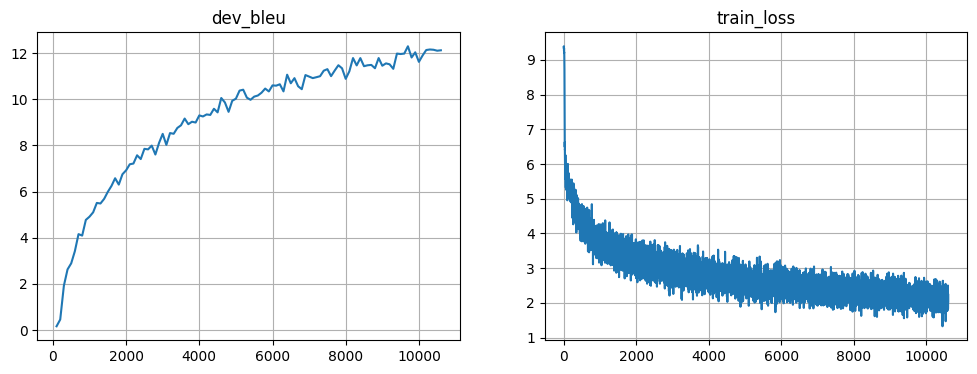

Mean loss=2.159


 71%|███████▏  | 10699/15000 [15:19<06:09, 11.64it/s]


In [ ]:
for _ in trange(15000):
    step = len(metrics['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device)
    batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)

    opt.zero_grad()
    loss_t = compute_loss(model, batch_inp, batch_out)
    loss_t.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
    opt.step()

    metrics['train_loss'].append((step, loss_t.item()))

    if step % 100 == 0:
        dev_bleu = compute_bleu(model, dev_inp, dev_out)
        metrics['dev_bleu'].append((step, dev_bleu))

        # вводим early stopping
        if dev_bleu > best_dev_bleu:
            best_dev_bleu = dev_bleu
            pat = 0
        else:
            pat += 100

        if pat >= early_stop_pat:
            break

        scheduler.step(-dev_bleu)

        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean([v for _, v in metrics['train_loss'][-10:]]), flush=True)

In [ ]:
# assert np.mean(metrics['dev_bleu'][-10:], axis=0)[1] > 15, "We kind of need a higher bleu BLEU from you. Kind of right now."

In [ ]:
for inp_line, trans_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500])[0]):
    print(inp_line)
    print(trans_line)
    print()

к услугам гостей бесплатные принадлежности для барбекю в саду и бесплатный wi - fi .
it offers a free wi - fi and free parking .

также имеется полностью оборудованная кухня с посудомоечной машиной .
there is also a full kitchen with a dishwasher and a microwave .

ежедневно сервируется завтрак « шведский стол ».
daily buffet breakfasts is served daily .

в ресторане отеля k@@ lau@@ s@@ nerhof гостям предложат блюда австрийской и интернациональной кухни , а в баре , работающим днем , гости могут заказать закуски .
the restaurant ’ s restaurant serves traditional polish and regional specialities in the lobby bar .

летом гости могут бесплатно пользоваться принадлежностями для барбекю .
free wifi is offered at the property , and a shared kitchen is available .

к услугам гостей ресторан и бесплатная частная парковка на территории .
guests of the hotel can enjoy free parking on site and a fully equipped kitchen .

до торгового комплекса mu@@ ir station можно доехать за 5 минут .
the train

In [ ]:
compute_bleu(model, dev_inp, dev_out)

12.031046872203822

### Attention

Attention-слой пока что оставим таким же

In [ ]:
class AttentionLayer(nn.Module):
    def __init__(self, enc_size, dec_size, hid_size):
        """ A layer that computes additive attention response and weights """
        super().__init__()
        self.enc_size = enc_size # num units in encoder state
        self.dec_size = dec_size # num units in decoder state
        self.hid_size = hid_size # attention layer hidden units

        self.linear_enc = nn.Linear(enc_size, hid_size)
        self.linear_dec = nn.Linear(dec_size, hid_size)
        self.linear_out = nn.Linear(hid_size, 1)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, enc, dec, inp_mask):
        """
        Computes attention response and weights
        :param enc: encoder activation sequence, float32[batch_size, ninp, enc_size]
        :param dec: single decoder state used as "query", float32[batch_size, dec_size]
        :param inp_mask: mask on enc activatons (0 after first eos), float32 [batch_size, ninp]
        :returns: attn[batch_size, enc_size], probs[batch_size, ninp]
            - attn - attention response vector (weighted sum of enc)
            - probs - attention weights after softmax
        """
        batch_size, ninp, enc_size = enc.shape

        # Compute logits
        x = self.linear_dec(dec).reshape(-1, 1, self.hid_size)
        x = torch.tanh(self.linear_enc(enc) + x)
        x = self.linear_out(x)

        # Apply mask - if mask is 0, logits should be -inf or -1e9
        # You may need torch.where
        x[torch.where(inp_mask == False)] = -1e9

        # Compute attention probabilities (softmax)
        probs = self.softmax(x.reshape(batch_size, ninp))

        # Compute attention response using enc and probs
        attn = (probs.reshape(batch_size, ninp, 1) * enc).sum(1)

        return attn, probs

### Seq2seq model + attention


In [ ]:
class AttentiveModel(BasicModel):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128, attn_size=128):
        """ Translation model that uses attention. See instructions above. """
        super().__init__(inp_voc, out_voc, emb_size, hid_size)
        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size

        self.enc0 = nn.LSTM(emb_size, hid_size, num_layers=2, batch_first=True)
        self.dec_start = nn.Linear(hid_size, hid_size)

        self.dec0 = nn.GRUCell(emb_size + hid_size, hid_size)
        self.attention = AttentionLayer(hid_size, hid_size, attn_size)


    def encode(self, inp, **flags):
        """
        Takes input sequences, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :return: a list of initial decoder state tensors
        """
        # encode input sequence, create initial decoder states
        inp_emb = self.emb_inp(inp)
        enc_seq, last_state_but_not_really = self.enc0(inp_emb)
        #[dec_start] = super().encode(inp, **flags)

        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        # ^-- shape: [batch_size, hid_size]
        dec_start = self.dec_start(last_state)

        # apply attention layer from initial decoder hidden state
        inp_mask = self.out_voc.compute_mask(inp)
        first_attn_probas = self.attention(enc_seq, dec_start, inp_mask)

        # Build first state: include
        # * initial states for decoder recurrent layers
        # * encoder sequence and encoder attn mask (for attention)
        # * make sure that last state item is attention probabilities tensor

        first_state = [dec_start, enc_seq, inp_mask, first_attn_probas]
        return first_state

    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits for next tokens
        :param prev_state: a list of previous decoder state tensors
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch, n_tokens]
        """

        prev_gru0_state, enc_seq, enc_mask, _ = prev_state
        attn, attn_probs = self.attention(enc_seq, prev_gru0_state, enc_mask)

        x = self.emb_out(prev_tokens)
        x = torch.cat([attn, x], dim=-1)
        x = self.dec0(x, prev_gru0_state)

        new_dec_state = [x, enc_seq, enc_mask, attn_probs]
        output_logits = self.logits(x)
        return [new_dec_state, output_logits]


### Training loop - модель с Attention


In [ ]:
metrics = {'train_loss': [], 'dev_bleu': [] }

model = AttentiveModel(inp_voc, out_voc).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=300, verbose=True)
batch_size = 32

best_dev_bleu = -float('inf')
pat = 0
early_stop_pat = 1500

In [ ]:
model

AttentiveModel(
  (emb_inp): Embedding(22892, 64)
  (emb_out): Embedding(19380, 64)
  (enc0): LSTM(64, 128, num_layers=2, batch_first=True)
  (dec_start): Linear(in_features=128, out_features=128, bias=True)
  (dec0): GRUCell(192, 128)
  (logits): Linear(in_features=128, out_features=19380, bias=True)
  (attention): AttentionLayer(
    (linear_enc): Linear(in_features=128, out_features=128, bias=True)
    (linear_dec): Linear(in_features=128, out_features=128, bias=True)
    (linear_out): Linear(in_features=128, out_features=1, bias=True)
    (softmax): Softmax(dim=-1)
  )
)

In [ ]:
compute_bleu(model, dev_inp, dev_out)

0.0012157082672438304

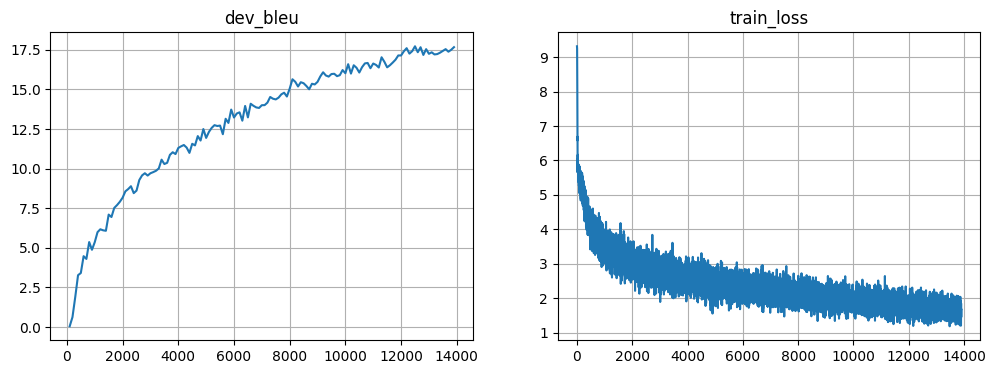

Mean loss=1.617


 93%|█████████▎| 13999/15000 [38:17<02:44,  6.09it/s]


In [ ]:
for _ in trange(15000):
    step = len(metrics['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device)
    batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)

    opt.zero_grad()
    loss_t = compute_loss(model, batch_inp, batch_out)
    loss_t.backward()
    opt.step()

    metrics['train_loss'].append((step, loss_t.item()))

    if step % 100 == 0:
        dev_bleu = compute_bleu(model, dev_inp, dev_out)
        metrics['dev_bleu'].append((step, dev_bleu))

        # вводим early stopping
        if dev_bleu > best_dev_bleu:
            best_dev_bleu = dev_bleu
            pat = 0
        else:
            pat += 100

        if pat >= early_stop_pat:
            break

        scheduler.step(-dev_bleu)

        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)


In [ ]:
compute_bleu(model, dev_inp, dev_out)

17.268546811782347

In [ ]:
for inp_line, trans_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500])[0]):
    print(inp_line)
    print(trans_line)
    print()

к услугам гостей бесплатные принадлежности для барбекю в саду и бесплатный wi - fi .
free wifi is available in public areas .

также имеется полностью оборудованная кухня с посудомоечной машиной .
there is a full kitchen with a dishwasher .

ежедневно сервируется завтрак « шведский стол ».
a daily buffet breakfast is served .

в ресторане отеля k@@ lau@@ s@@ nerhof гостям предложат блюда австрийской и интернациональной кухни , а в баре , работающим днем , гости могут заказать закуски .
the on - site restaurant serves international cuisine and international dishes , while the hotel has a wide range of refreshing drinks and drinks and snacks .

летом гости могут бесплатно пользоваться принадлежностями для барбекю .
bbq facilities are available in public areas of the property .

к услугам гостей ресторан и бесплатная частная парковка на территории .
it offers a restaurant and free on - site parking .

до торгового комплекса mu@@ ir station можно доехать за 5 минут .
the kamala city of san

## Выводы:

Метрики при изначальных параметрах обработки данных и построения модели:

    BLEU no attention: 18.5
    Loss no attention: 1.7


    BLEU with attention: 22.9
    Loss with attention: 1.6


Метрики после
- увеличения размера словаря до 25 тыс. токенов
- изменения однослойной gru архитектуры на двухслойную lstm
- улучения training-процесса: lr sheduling, early stopping и т.п.
- замены жадного семплирования на топ-к


    BLEU no attention: 12.03
    Loss no attention: 2.16

    BLEU with attention: 17.2
    Loss with attention: 1.6


Из улучшений самого метода исследования можно добавить исполнение кода после каждого изменения архитектуры, что в этот раз не было сделано. Модель дает результаты хуже после подбора параметров и комбинирования различных иструментов, что, естественно, плохо и нужно донастраивать весь пайплайн с фиксацией изменений метрик после различных изменений параметров. И насколько я понимаю тот же loss при более низком bleu говорит о переобучении, буду очень рада подсказкам что можно поменять в текущем решении чтобы повысить метрики/что из подобранных параметров могло повлиять негативно на результат.